# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [4]:
df = pd.read_csv('autos.csv') #использовалость для запуска на локальной машине
#df = pd.read_csv('/datasets/autos.csv')
df


#print(df['NumberOfPictures'].unique()) ---- для прооверки кол-ва уникальных значений в столбце NumberOfPictures

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
df.columns=['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', \
                 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', \
                 'last_seen']

df.drop(['last_seen'], axis=1, inplace=True)

#df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y%m%d %H:%M:%S')
#df['date_created'] = pd.to_datetime(df['date_created'], format='%Y%m%d %H:%M:%S')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 40.6+ MB


В нашем случае, категоральные признаки с пропусками мы никак не можем больше обработать, кроме как удалить, потому что все эти признаки важны для обучения модели и могут влиять на цену автомобиля

In [8]:
data = df
data.fillna('unknown', inplace=True)
print(data.isna().sum())

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
dtype: int64


In [9]:
print(data.duplicated().sum())
display(data[data.duplicated()])

19


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code
116439,2016-03-22 21:58:18,1500,sedan,2001,manual,116,stilo,150000,11,gasoline,fiat,no,2016-03-22 00:00:00,0,41564
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518
179521,2016-03-19 13:36:23,8750,small,2012,manual,69,polo,40000,8,petrol,volkswagen,no,2016-03-19 00:00:00,0,96247
209732,2016-04-02 10:43:57,1990,coupe,2000,manual,125,other,150000,6,petrol,ford,no,2016-04-02 00:00:00,0,53797
216300,2016-03-21 19:46:53,15299,sedan,2004,auto,367,c_klasse,150000,9,petrol,mercedes_benz,no,2016-03-21 00:00:00,0,22850
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589
232438,2016-03-22 01:51:32,2000,sedan,1999,manual,150,3er,150000,11,petrol,bmw,no,2016-03-22 00:00:00,0,35683
254900,2016-03-13 17:06:23,9000,coupe,2005,auto,218,crossfire,60000,3,petrol,chrysler,no,2016-03-13 00:00:00,0,61476
255297,2016-03-19 20:54:35,1450,small,2001,manual,107,clio,150000,12,petrol,renault,no,2016-03-19 00:00:00,0,51647
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196


In [10]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [11]:
cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
col = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']

In [12]:
for i in data.columns:
    print(data[i].describe(), '\n')

count                  354350
unique                 271174
top       2016-03-24 14:49:47
freq                        7
Name: date_crawled, dtype: object 

count    354350.000000
mean       4416.618626
std        4514.167595
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64 

count     354350
unique         9
top        sedan
freq       91453
Name: vehicle_type, dtype: object 

count    354350.000000
mean       2004.234610
std          90.230358
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64 

count     354350
unique         3
top       manual
freq      268238
Name: gearbox, dtype: object 

count    354350.000000
mean        110.092448
std         189.854610
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtyp

price


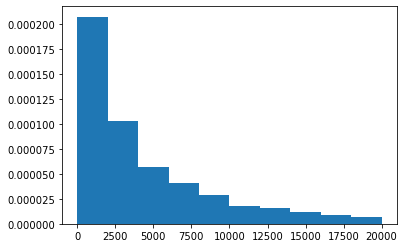

registration_year


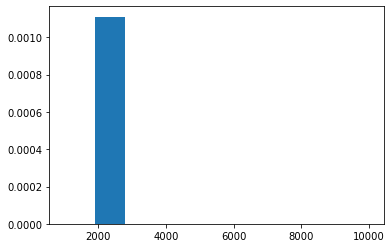

power


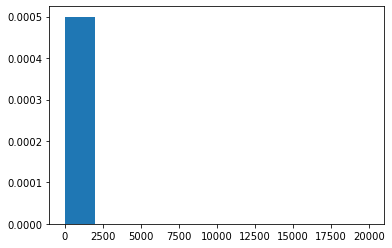

kilometer


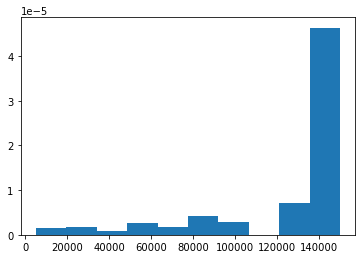

registration_month


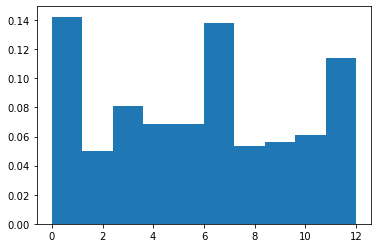

number_of_pictures


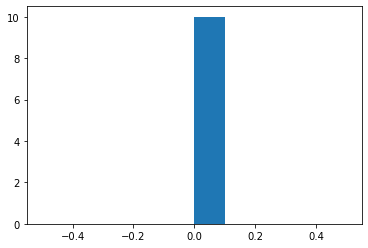

postal_code


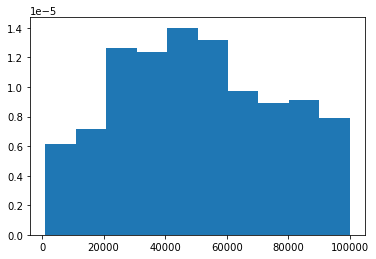

In [13]:
for i in col:
    plt.hist(data[i], label=i, density=True)
    print(i)
    plt.show()

In [14]:
print(data['number_of_pictures'].unique()) # как можно заметить, столбец number_of_pictures не имеет никаких больше значений, кроме как 0, \
                                  #поэтому его можно удалить 
    
data.drop(['number_of_pictures'], axis=1, inplace=True)


[0]


In [15]:
array = []
for i in range(data['date_crawled'].shape[0]):
    array.append(int(data.loc[i, 'date_crawled'][:4]))

data = data[data['registration_year'] < max(array)]
print(max(data['registration_year'].unique()))

2015


In [16]:
print(data[data['price'] == 0]['price'].count())

9390


In [17]:
data = data[data['price'] != 0]
print(data[data['price'] == 0]['price'].count())

0


In [18]:
data['vehicle_type'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

(array([ 35636.,  97977., 111489.,  52131.,  15908.,   4262.,   2318.,
           418.,    156.,    154.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <BarContainer object of 10 artists>)

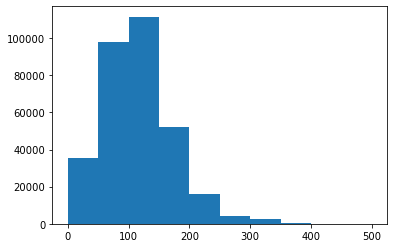

In [19]:
plt.hist(data['power'], range=(0, 500))

In [20]:
data = data[(data['power'] < 500) & (data['power'] > 50)]
data['power'].describe()

count    280635.000000
mean        123.462964
std          52.456764
min          51.000000
25%          83.000000
50%         116.000000
75%         150.000000
max         490.000000
Name: power, dtype: float64

In [21]:
print(data['registration_month'].unique())
print(data[data['registration_month'] == 12]['registration_year'].count())
print(data[data['registration_month'] == 0]['registration_year'].count())
print(max(data[data['registration_month'] == 12]['registration_year'].unique()))
print(max(data[data['registration_month'] == 0]['registration_year'].unique()))

[ 5  8  6  7 10  0 12 11  2  3  1  4  9]
20248
15509
2015
2015


In [22]:
data['registration_month'] = data[data['registration_month'] == 0]['registration_month'] = 1 

In [23]:
print(data[data['registration_month'] == 0]['registration_month'].count())

0


In [24]:
data['fuel_type'].unique()

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [25]:
data['postal_code'].nunique()

8102

В остальных случаях изменять ничего не нужно. Осталось удалить столбец date_crawled, ведь это информация не нужна моделе для обучения. Данный столбец существует исключительно для предобработки и нашего удобства

## Обучение моделей

In [26]:
data

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,postal_code
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,1,gasoline,audi,yes,2016-03-24 00:00:00,66954
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,1,gasoline,jeep,unknown,2016-03-14 00:00:00,90480
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,1,petrol,volkswagen,no,2016-03-17 00:00:00,91074
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,1,gasoline,skoda,no,2016-03-31 00:00:00,60437
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,1,petrol,bmw,yes,2016-04-04 00:00:00,33775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354340,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,1,gasoline,volkswagen,no,2016-03-28 00:00:00,75223
354343,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,1,petrol,seat,yes,2016-03-19 00:00:00,96465
354347,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,1,petrol,smart,no,2016-03-05 00:00:00,26135
354348,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,1,gasoline,volkswagen,no,2016-03-19 00:00:00,87439


In [27]:
target = data['price']
features = data.drop(['date_crawled', 'price', 'date_created'], axis=1)
cat = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [28]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, \
                                                                              test_size=0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, \
                                                                            test_size=0.25, random_state=12345)

### Catboost

In [29]:
model_catboost = CatBoostRegressor(iterations=200, depth=10, loss_function='RMSE', learning_rate=0.3) 

In [30]:
%%time
model_catboost.fit(features_train, target_train, cat_features=cat, verbose=10)

0:	learn: 3620.8108222	total: 326ms	remaining: 1m 4s
10:	learn: 1765.2171824	total: 1.94s	remaining: 33.3s
20:	learn: 1650.7152209	total: 3.59s	remaining: 30.6s
30:	learn: 1592.4536490	total: 5.24s	remaining: 28.5s
40:	learn: 1559.3741550	total: 6.9s	remaining: 26.8s
50:	learn: 1526.2165642	total: 8.51s	remaining: 24.9s
60:	learn: 1503.7003410	total: 10.2s	remaining: 23.2s
70:	learn: 1481.2141063	total: 11.8s	remaining: 21.5s
80:	learn: 1465.7423955	total: 13.5s	remaining: 19.8s
90:	learn: 1449.3232233	total: 15.5s	remaining: 18.5s
100:	learn: 1436.1895175	total: 17.1s	remaining: 16.7s
110:	learn: 1422.4675069	total: 18.8s	remaining: 15s
120:	learn: 1410.2615546	total: 20.5s	remaining: 13.4s
130:	learn: 1397.3196162	total: 22.3s	remaining: 11.7s
140:	learn: 1388.2714035	total: 23.9s	remaining: 10s
150:	learn: 1379.0327829	total: 25.7s	remaining: 8.34s
160:	learn: 1368.8651742	total: 27.4s	remaining: 6.65s
170:	learn: 1357.9763891	total: 29.1s	remaining: 4.94s
180:	learn: 1350.8252759	t

In [31]:
%%time
prediction = model_catboost.predict(features_test)
print(mean_squared_error(target_test, prediction, squared=False))

1552.286216436875
CPU times: total: 344 ms
Wall time: 159 ms


In [32]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
#cat_columns = data.select_dtypes(include=['object']).columns # название датафрейма может отличаться

encoder.fit(features_train[cat])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat] = encoder.transform(features_train_ord[cat])
features_valid_ord[cat] = encoder.transform(features_valid_ord[cat])
features_test_ord[cat] = encoder.transform(features_test_ord[cat])

In [33]:
features_train_ord

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
27452,2.0,1999,1.0,170,11.0,150000,1,6.0,2.0,0.0,68309
234304,5.0,2002,1.0,75,8.0,150000,1,6.0,25.0,0.0,75181
88984,5.0,1998,1.0,60,127.0,80000,1,6.0,10.0,0.0,64347
266894,5.0,2011,1.0,73,8.0,125000,1,6.0,25.0,2.0,35781
228962,0.0,2001,1.0,151,221.0,150000,1,2.0,38.0,0.0,37441
...,...,...,...,...,...,...,...,...,...,...,...
145847,4.0,2001,1.0,75,32.0,125000,1,2.0,20.0,2.0,32602
93911,8.0,2006,0.0,140,169.0,150000,1,2.0,38.0,0.0,39340
211591,8.0,2006,1.0,150,202.0,150000,1,2.0,24.0,0.0,32825
206400,4.0,2008,1.0,80,115.0,60000,1,6.0,38.0,0.0,89075


In [34]:
features_train_ord.columns.values.tolist ()

['vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'postal_code']

In [35]:
cat = features_train_ord.drop(['registration_year', 'power', 'kilometer', \
                               'registration_month', 'postal_code'], axis=1).columns

### LGBMRegressor

In [36]:
%%time
parametrs = { 'n_estimators': range (10, 101, 3),
               'max_depth': range (1,16)}
model = RandomizedSearchCV(LGBMRegressor(), param_distributions=parametrs, cv=5, n_jobs=-1, verbose=1, random_state=12345)

CPU times: total: 0 ns
Wall time: 0 ns


In [37]:
%%time
model_grid = model.fit(features_train_ord, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: total: 1.66 s
Wall time: 12.8 s


In [38]:
%%time
#model.fit(features_train, target_train)
print(model_grid.best_estimator_)
print(model_grid.best_score_)

LGBMRegressor(max_depth=14, n_estimators=97)
0.8709974689202233
CPU times: total: 0 ns
Wall time: 2 ms


In [39]:
model_lgbmr = LGBMRegressor(max_depth=14, n_estimators=97, random_state=12345, n_jobs=-1)

In [40]:
%%time
model_lgbmr.fit(features_train_ord, target_train)

CPU times: total: 1.53 s
Wall time: 407 ms


LGBMRegressor(max_depth=14, n_estimators=97, random_state=12345)

In [41]:
%%time
prediction = model_lgbmr.predict(features_test_ord)
print(mean_squared_error(target_test, prediction, squared=False))

1678.6445719360024
CPU times: total: 344 ms
Wall time: 86.8 ms


### RandomForestRegressor

In [42]:
parametrs = { 'n_estimators': range (30, 101, 4),
               'max_depth': range (3,16)}

model = RandomizedSearchCV(RandomForestRegressor(), param_distributions=parametrs, cv=5, n_jobs=-1, verbose=1, random_state=12345)

In [43]:
%%time
model_grid = model.fit(features_train_ord, target_train)
print(model_grid.best_estimator_)
print(model_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(max_depth=14, n_estimators=54)
0.8724051001803975
CPU times: total: 17.4 s
Wall time: 4min 2s


In [44]:
model_forest = RandomForestRegressor(max_depth=14 , n_estimators=54 , random_state=12345, verbose=1)

In [45]:
%%time
model_forest.fit(features_train_ord, target_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: total: 17.2 s
Wall time: 17.1 s


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   17.0s finished


RandomForestRegressor(max_depth=14, n_estimators=54, random_state=12345,
                      verbose=1)

In [46]:
%%time
prediction = model_forest.predict(features_test_ord)
print(mean_squared_error(target_test, prediction, squared=False))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1643.003790914896
CPU times: total: 406 ms
Wall time: 401 ms


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.3s finished


## Анализ моделей

Быстрее всех обучается модель LGBMRegressor: 
   * CPU times: total: 1.88 s
   * Wall time: 14.8 s
   
\
Быстрее всех предсказывает модель LGBMRegressor:
   * CPU times: total: 344 ms
   * Wall time: 92.8 ms

\
Наилучшее качество у модели CatBoostRegressor:
   * RMSE = 1552.286216436875 - на тестовой выборке 
   

In [47]:
d = {'name' : ['CatBoostRegressor', 'LGBMRegressor', 'RandomForestRegressor'], \
     'fit_time_in_sec' : [152.9, 1.913, 36.2], \
     'predict_time_in_ms' : [533, 436.8, 846], \
     'RMSE' : [1552.286, 1678.645, 1643.004]}

result_table = pd.DataFrame(data=d)
result_table

,name,fit_time_in_sec,predict_time_in_ms,RMSE
0,CatBoostRegressor,152.900,533.0,1552.286
1,LGBMRegressor,1.913,436.8,1678.645
2,RandomForestRegressor,36.200,846.0,1643.004


Несмотря на нато, что catboost намного дольше обучается и немного дольше предсказывает, я бы порекомендовал заказчику использовать именно модель CatBoostRegressor со следующими гиперпараметрами: 
   * iterations=200 
   * depth=10 
   * loss_function='RMSE' 
   * learning_rate=0.3 
   
Так как RMSE у этой модели значительно меньше, чем у остальных. Стоит также добавить, что если учитывать время, которое нужно на подбор гиперпараметров, то catboost будет быстрее своих конкурентов

## Тестирование лучшей модели

Лучшей моделью оказалась CatBoostRegressor со значением RMSE=1552.286216436875 на тестовой выборке. \
Проверим ее качество на валидационной

In [48]:
%%time
prediction = model_catboost.predict(features_valid)
print(mean_squared_error(target_valid, prediction, squared=False))

1573.3815901894914
CPU times: total: 344 ms
Wall time: 157 ms


Результат отличный. Он не сильно отличается от того, который мы получили на тестовой выборке, а значит модель работает корректно